In [1]:
from load import load_batched, num_images, load
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import cv2 as cv
import random
from tqdm.notebook import tqdm
import math
import matplotlib.image as mimage
import pathlib

In [2]:
def random_crop(dims, crop_dims):
    offset_0 = dims[0] - crop_dims[0]
    offset_1 = dims[1] - crop_dims[1]

    return int(offset_0 * random.random()), int(offset_1 * random.random())

def crop_pad(dims, crop_dims, crop, pad_mult=16):
    final_dim0 = crop_dims[0] + (-crop_dims[0] % pad_mult)
    final_dim1 = crop_dims[1] + (-crop_dims[1] % pad_mult)

    if final_dim0 > dims[0] or final_dim1 > dims[1]:
        return None

    overage0 = crop[0] + final_dim0 - dims[0]
    overage1 = crop[1] + final_dim1 - dims[1]

    new_crop = (crop[0] - max(0, overage0), crop[1] - max(0, overage1))

    return new_crop, (final_dim0, final_dim1)

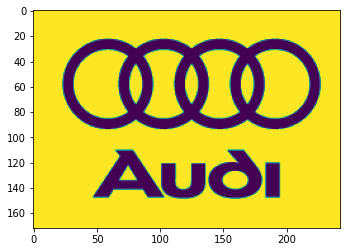

In [3]:
logos = list(pathlib.Path('Logos').iterdir())
logo_ims = [mimage.imread(path) for path in logos]
plt.imshow(logo_ims[2])

In [4]:
#  wm-nowm/train/no-watermark/pexels-photo-2350345.png
print(num_images())
# for batch_idx, ims in tqdm(enumerate(load_batched(50)), total=num_images()//50):
#     for im_idx, im in enumerate(ims):
#         if len(im.shape) < 3:
#             print('Dumb Image:', _list_files(data_dir='wm-nowm')[batch_idx * 50 + im_idx])
#             print(im.shape)
#             plt.figure()
#             plt.imshow(im)

15328


In [5]:
out_dir = pathlib.Path('logos_rendered')
out_dir.mkdir(exist_ok=True)

with open(out_dir.joinpath('bb.csv'), 'w') as bb_file:
    no = out_dir.joinpath('no')
    no.mkdir(exist_ok=True)
    wm = out_dir.joinpath('wm')
    wm.mkdir(exist_ok=True)
    full_wm = out_dir.joinpath('full_wm')
    full_wm.mkdir(exist_ok=True)
    full_no = out_dir.joinpath('full_no')
    full_no.mkdir(exist_ok=True)

    for batch_id, ims in tqdm(enumerate(load_batched(50)), total=num_images()//50):
        for im_id, (im, (logo_id, logo)) in enumerate(zip(ims, cycle(enumerate(logo_ims)))):
            if im.ndim == 2:
                # Stupid indexed color webp/gif idiocy
                continue
            idx = batch_id * 50 + im_id
            im_name = f'{idx}.jpg'

            crop = random_crop(im.shape, tuple(dim + 16 for dim in logo.shape))
            result = crop_pad(im.shape, tuple(dim + 16 for dim in logo.shape), crop)
            if result is None:
                continue
            pad_crop, crop_size = result

            plt.imsave(full_no.joinpath(im_name), im)
            plt.imsave(no.joinpath(im_name), im[pad_crop[0]:pad_crop[0] + crop_size[0], pad_crop[1]:pad_crop[1] + crop_size[1]])

            cropped_im = im[pad_crop[0]:pad_crop[0] + crop_size[0], pad_crop[1]:pad_crop[1] + crop_size[1]]
            random_jitter = (random.randint(4, 12), random.randint(4, 12))
            slices = tuple(
                slice(jitter, jitter+shape) for jitter, shape in zip(random_jitter, logo.shape)
            )
            orig_slices = tuple(
                slice(crop + jitter, crop + jitter+shape) for jitter, shape, crop in zip(random_jitter, logo.shape, pad_crop)
            )
            cropped_im[slices[0], slices[1]] = cropped_im[slices[0], slices[1]] * (np.minimum(logo[..., None]/2+0.05, 0.5) + 0.5)
            wm_im = im.copy()
            wm_im[orig_slices[0], orig_slices[1]] = wm_im[orig_slices[0], orig_slices[1]] * (np.minimum(logo[..., None]/2+0.05, 0.5) + 0.5)
            plt.imsave(wm.joinpath(im_name), cropped_im)
            plt.imsave(full_wm.joinpath(im_name), wm_im)
            bb = (idx, logo_id, orig_slices[0].start, orig_slices[1].start, orig_slices[0].stop, orig_slices[1].stop)
            print(', '.join(str(n) for n in bb), file=bb_file)


  0%|          | 0/306 [00:00<?, ?it/s]